In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn.metrics import f1_score


In [2]:
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
os.environ['CUDA_LAUNCH_BLOCKING']="1"
print(device)
print(f'torch version : {torch.__version__}')

cuda:1
torch version : 1.12.1


In [3]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':100,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
df = pd.read_csv('./Dataset/train.csv')
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [6]:
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)
print(df.head())
print(len(set(df['artist'].values)))
print(len(le.classes_))

   id          img_path  artist
0   0  ./train/0000.jpg       9
1   1  ./train/0001.jpg      48
2   2  ./train/0002.jpg       7
3   3  ./train/0003.jpg      10
4   4  ./train/0004.jpg      24
50
50


In [7]:
train_df,val_df,_, _ = train_test_split(df, df['artist'].values, test_size=0.2, random_state=CFG['SEED'])

In [8]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].values
    return df['img_path'].values, df['artist'].values

In [9]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [10]:
from sklearn.preprocessing import label_binarize


class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms
    
    def __getitem__(self, index):
        img_path = './Dataset'+self.img_paths[index][1:]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.labels is not None:
            label = torch.zeros([50], dtype=torch.float32)
            label[self.labels[index]] = 1
            
            return image, label
        else:
            return image
    def __len__(self):
        return len(self.img_paths)      

In [11]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224,224),
    A.HorizontalFlip( p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, p=0.5),
    # A.CoarseDropout(max_holes=2, max_height=32, max_width=32, 
    #                          min_holes=None, min_height=32, min_width=32,always_apply=False, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229,0.224,0.224), max_pixel_value=255),
    #A.Normalize(max_pixel_value=255),
    # (HxWxC) -> (CxHxW)
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    #A.Normalize(max_pixel_value=255),
    A.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229,0.224,0.224), max_pixel_value=255),
    ToTensorV2()
])

In [12]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

val_dataset = CustomDataset(val_img_paths,val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

torch.Size([16, 3, 224, 224]) tensor([0.0020, 0.0020, 0.9020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020])
tensor(2.6518) tensor(-2.1179)


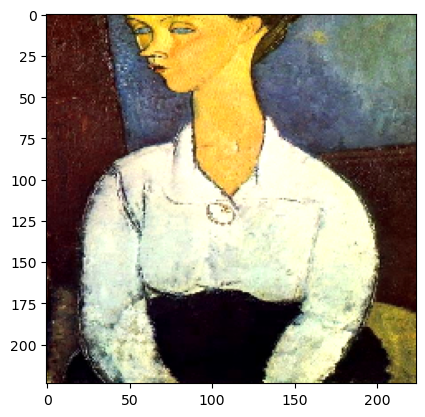

In [13]:
import matplotlib.pyplot as plt
img_mean=(0.485, 0.456, 0.406)
img_std= (0.229,0.224,0.224)
t,l = next(iter(train_loader))
print(t.shape,l[0])
print(torch.max(t[0]), torch.min(t[0]))
t[0]= t[0] * torch.tensor(img_std).view(3, 1, 1) + torch.tensor(img_mean).view(3, 1, 1)
plt.imshow(t[0].detach().cpu().numpy().transpose(1,2,0))

In [14]:
from torchvision.models import convnext_large,ConvNeXt_Large_Weights
from torchvision import models

import timm
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        #self.backbone = convnext_large(weight=ConvNeXt_Large_Weights.DEFAULT)
        # self.backbone = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)
        self.backbone = models.convnext_small(weights=models.ConvNeXt_Small_Weights.IMAGENET1K_V1)
        
        #self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        self.drop = nn.Dropout(0.5,inplace=True)
    def forward(self, x):
        x = self.backbone(x)
        x = self.drop(x)
        x = self.classifier(x)
        return x

In [15]:
import torchsummary
model = BaseModel()
torchsummary.summary(model, (3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

CustomLoss
#pytorch 참고

In [16]:
def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py

    p = torch.sigmoid(inputs)
    # label smoothing
    targets = targets*(1-0.1)+0.1/50
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss

In [17]:
from torchvision.ops import focal_loss

def train(model, optimizer, trian_loader, test_loader, scheduler, device):
    model.to(device)
    history = {'train_loss':[],'val_loss':[],'f1_score':[]}
    #criterion = nn.CrossEntropyLoss().to(device)
    criterion = focal_loss.sigmoid_focal_loss

    best_score = 0
    count = 0
    for epoch in range(1,CFG['EPOCHS']):
        model.train()
        train_loss = []
        for img , label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.to(device)
            optimizer.zero_grad()

            model_pred = model(img)

            loss = criterion(model_pred, label)

            loss.mean().backward()
            optimizer.step()

            train_loss.append(loss.mean().item())
            #print(loss.item())
            #break
        tr_loss  = np.mean(np.array(train_loss))

        val_loss, val_score = validation(model,criterion, test_loader, device)

        print(f'Epoch [{epoch}], Train Loss : {tr_loss:.5f}, Val Loss : {val_loss:.5f}, Val F1 Score : {val_score:.5f}')

        history['train_loss'].append(tr_loss)
        history['val_loss'].append(val_loss)
        history['f1_score'].append(val_score)

        if scheduler is not None:
            scheduler.step()
        if best_score < val_score:
            best_model = model
            best_score = val_score
            if val_score > 0.7:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                },f'./checkpoint/best_{val_score:.4f}.pth')
                print('Model Saved')
        else:
            if count >5:
                print('early stopping')
                break
            count +=1
    return history

In [18]:
def competition_metric(true,pred):
    return f1_score(true,pred,average='macro')

def validation(model, criterion,test_loader, device):
    model.eval()

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.to(device)

            model_pred = model(img)

            loss = criterion(model_pred, label)

            val_loss.append(loss.mean().item())
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.argmax(1).detach().cpu().numpy().tolist()
    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

In [19]:
optimizer = torch.optim.Adam(params=model.parameters(), lr = 5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=1,T_mult=2,eta_min=5e-7)

history = train(model, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 74/74 [00:17<00:00,  4.23it/s]


Epoch [1], Train Loss : 0.01458, Val Loss : 0.00777, Val F1 Score : 0.05571


100%|██████████| 74/74 [00:16<00:00,  4.36it/s]


Epoch [2], Train Loss : 0.00805, Val Loss : 0.00619, Val F1 Score : 0.19084


100%|██████████| 74/74 [00:16<00:00,  4.47it/s]


Epoch [3], Train Loss : 0.00672, Val Loss : 0.00521, Val F1 Score : 0.31529


100%|██████████| 74/74 [00:16<00:00,  4.37it/s]


Epoch [4], Train Loss : 0.00590, Val Loss : 0.00438, Val F1 Score : 0.43128


100%|██████████| 74/74 [00:17<00:00,  4.33it/s]


Epoch [5], Train Loss : 0.00495, Val Loss : 0.00405, Val F1 Score : 0.51556


100%|██████████| 74/74 [00:16<00:00,  4.50it/s]


Epoch [6], Train Loss : 0.00422, Val Loss : 0.00352, Val F1 Score : 0.55999


100%|██████████| 74/74 [00:16<00:00,  4.45it/s]


Epoch [7], Train Loss : 0.00368, Val Loss : 0.00331, Val F1 Score : 0.61123


100%|██████████| 74/74 [00:16<00:00,  4.43it/s]


Epoch [8], Train Loss : 0.00396, Val Loss : 0.00327, Val F1 Score : 0.62827


100%|██████████| 74/74 [00:16<00:00,  4.52it/s]


Epoch [9], Train Loss : 0.00346, Val Loss : 0.00323, Val F1 Score : 0.66600


100%|██████████| 74/74 [00:16<00:00,  4.49it/s]


Epoch [10], Train Loss : 0.00290, Val Loss : 0.00309, Val F1 Score : 0.67298


100%|██████████| 74/74 [00:16<00:00,  4.51it/s]


Epoch [11], Train Loss : 0.00253, Val Loss : 0.00275, Val F1 Score : 0.70159
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.38it/s]


Epoch [12], Train Loss : 0.00216, Val Loss : 0.00267, Val F1 Score : 0.69846


100%|██████████| 74/74 [00:16<00:00,  4.57it/s]


Epoch [13], Train Loss : 0.00181, Val Loss : 0.00255, Val F1 Score : 0.74779
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.41it/s]


Epoch [14], Train Loss : 0.00166, Val Loss : 0.00252, Val F1 Score : 0.74806
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.51it/s]


Epoch [15], Train Loss : 0.00155, Val Loss : 0.00244, Val F1 Score : 0.75425
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.41it/s]


Epoch [16], Train Loss : 0.00215, Val Loss : 0.00302, Val F1 Score : 0.73153


100%|██████████| 74/74 [00:16<00:00,  4.50it/s]


Epoch [17], Train Loss : 0.00192, Val Loss : 0.00274, Val F1 Score : 0.72688


100%|██████████| 74/74 [00:16<00:00,  4.50it/s]


Epoch [18], Train Loss : 0.00173, Val Loss : 0.00284, Val F1 Score : 0.73454


100%|██████████| 74/74 [00:16<00:00,  4.44it/s]


Epoch [19], Train Loss : 0.00156, Val Loss : 0.00304, Val F1 Score : 0.73873


100%|██████████| 74/74 [00:16<00:00,  4.42it/s]


Epoch [20], Train Loss : 0.00126, Val Loss : 0.00276, Val F1 Score : 0.75286


100%|██████████| 74/74 [00:16<00:00,  4.50it/s]

Epoch [21], Train Loss : 0.00116, Val Loss : 0.00285, Val F1 Score : 0.75085
early stopping


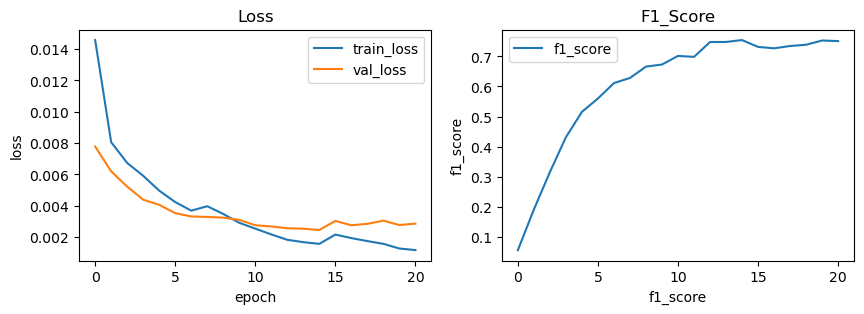

In [20]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(range(len(history['train_loss'])),history['train_loss'], label='train_loss')
plt.plot(range(len(history['train_loss'])),history['val_loss'], label='val_loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(history['f1_score'])), history['f1_score'], label='f1_score')
plt.title('F1_Score')
plt.ylabel('f1_score')
plt.xlabel('f1_score')
plt.legend()

plt.show()